# Group Work Project 3

Names: Rohan, Stefan, Alfonso

Step 1

a. gather time series data

b. predictive modeling

c. DL models

    i. MLP
    
    ii. LSTM

    iii. CNN based on GAF

d. backtests

# Global Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

### 1a.

In [2]:
# Fetch Data
ticker = 'AMD'
start = '2020-01-01'
end = '2023-01-01'
interval = '1d'

data = yf.download(ticker, start=start, end=end, interval=interval, progress=False, auto_adjust=False)

if data.empty:
    raise ValueError(f"No data returned for {ticker} with interval={interval}. "
                "Try a coarser interval or different date range.")

data.columns = data.columns.get_level_values(0)
df = data[['Close']].copy()
df.index = pd.to_datetime(df.index).tz_localize(None)
df.sort_index(inplace=True)


print(type(df))
print(df)

<class 'pandas.core.frame.DataFrame'>
Price           Close
Date                 
2020-01-02  49.099998
2020-01-03  48.599998
2020-01-06  48.389999
2020-01-07  48.250000
2020-01-08  47.830002
...               ...
2022-12-23  64.519997
2022-12-27  63.270000
2022-12-28  62.570000
2022-12-29  64.820000
2022-12-30  64.769997

[756 rows x 1 columns]


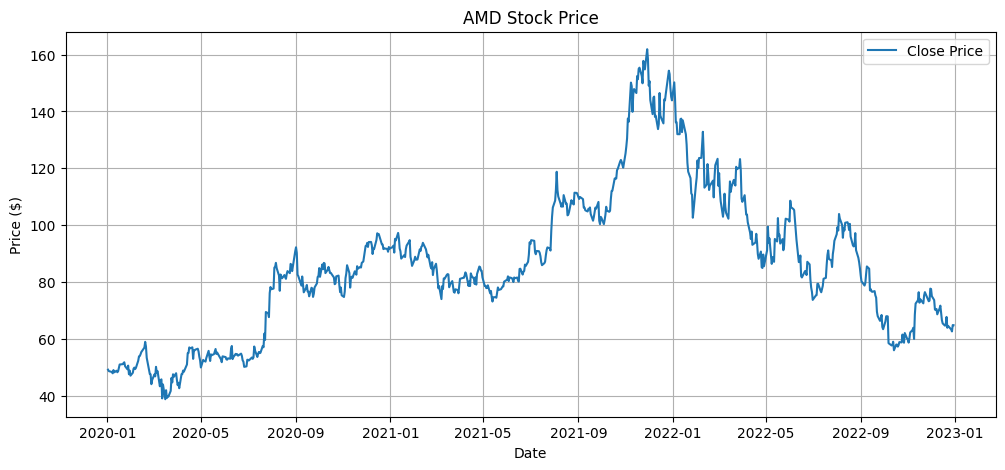

In [3]:
# Visualizations

plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

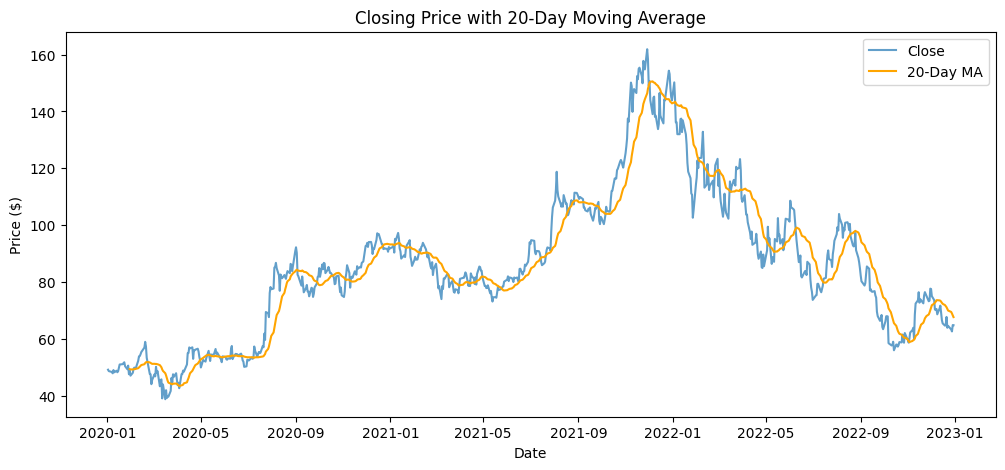

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Close', alpha=0.7)
plt.plot(data['Close'].rolling(window=20).mean(), label='20-Day MA', color='orange')
plt.title("Closing Price with 20-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()


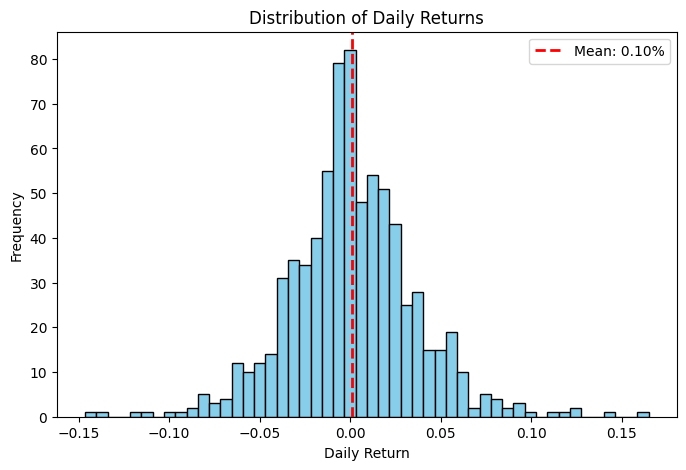

In [ ]:
returns = data['Close'].pct_change().dropna()

plt.figure(figsize=(8, 5))
plt.hist(returns, bins=50, color='skyblue', edgecolor='k')
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.axvline(returns.mean().item(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {returns.mean().item():.2%}")
plt.legend()
plt.show()

In [4]:
def describe_close(df: pd.DataFrame) -> str:
    """
    Produce a textual description of the Close column in a DataFrame.
    Assumes a datetime index and a 'Close' column.
    Returns a formatted multi-line string.
    """
    import numpy as np

    if 'Close' not in df.columns:
        raise ValueError("DataFrame must contain a 'Close' column.")

    close = df['Close'].dropna().copy()
    if close.empty:
        return "The 'Close' series is empty after dropping NaNs."

    # Ensure index is datetime for formatting
    try:
        close.index = pd.to_datetime(close.index)
    except Exception:
        # If index can't be converted, we'll still proceed but avoid date formatting that depends on datetime
        pass

    # Time info
    start_date = close.index.min()
    end_date = close.index.max()
    n_obs = int(close.shape[0])

    # Helper to safely coerce statistics to python float
    def _to_float(x):
        try:
            return float(x)
        except Exception:
            # fallback if x is None or not numeric
            return float('nan')

    # Stats
    min_price = _to_float(close.min())
    max_price = _to_float(close.max())
    mean_price = _to_float(close.mean())
    median_price = _to_float(close.median())
    std_price = _to_float(close.std())

    # Returns
    ret = close.pct_change().dropna()
    def fmt_pct(x):
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return "N/A"
        return f"{x:.2%}"

    ret_mean = _to_float(ret.mean()) if not ret.empty else float('nan')
    ret_std = _to_float(ret.std()) if not ret.empty else float('nan')
    ret_min = _to_float(ret.min()) if not ret.empty else float('nan')
    ret_max = _to_float(ret.max()) if not ret.empty else float('nan')

    # Format start/end dates safely (if index isn't datetime, convert to string)
    try:
        start_str = f"{start_date:%Y-%m-%d}"
        end_str = f"{end_date:%Y-%m-%d}"
    except Exception:
        start_str = str(start_date)
        end_str = str(end_date)

    text = (
        f"The dataset contains **{n_obs:,} observations** of the Close price\n"
        f"from {start_str} to {end_str}.\n\n"
        f"Summary statistics for the Close column:\n"
        f"- Minimum price: ${min_price:.2f}\n"
        f"- Maximum price: ${max_price:.2f}\n"
        f"- Mean (average): ${mean_price:.2f}\n"
        f"- Median: ${median_price:.2f}\n"
        f"- Standard deviation: ${std_price:.2f}\n\n"
        f"Daily percentage returns (based on Close) have:\n"
        f"- Mean: {fmt_pct(ret_mean)}\n"
        f"- Std dev: {fmt_pct(ret_std)}\n"
        f"- Min: {fmt_pct(ret_min)}\n"
        f"- Max: {fmt_pct(ret_max)}\n\n"
        f"Overall, prices range from about ${min_price:.2f} to ${max_price:.2f},\n"
        f"with an average around ${mean_price:.2f}. Volatility, as measured by\n"
        f"daily return standard deviation, is {ret_std:.4f} (raw decimal).\n"
    )

    return text


# Usage:
print(describe_close(data))

The dataset contains **756 observations** of the Close price
from 2020-01-02 to 2022-12-30.

Summary statistics for the Close column:
- Minimum price: $38.71
- Maximum price: $161.91
- Mean (average): $85.85
- Median: $83.81
- Standard deviation: $25.56

Daily percentage returns (based on Close) have:
- Mean: 0.10%
- Std dev: 3.50%
- Min: -14.64%
- Max: 16.50%

Overall, prices range from about $38.71 to $161.91,
with an average around $85.85. Volatility, as measured by
daily return standard deviation, is 0.0350 (raw decimal).



Textual Description of Data

Equity security, AMD, price data from beginning 2020 to end of 2022. The data has a minimum price of $38.71 and maximum price of 161.91 with an average of 85.85. The median is 83.81 and the data has a standard deviation of 25.26.

The daily percentage returns has a mean of 0.10%, standard deviation of 3.50%, and a min of -14.64% and max of 16.50%.

### 1b.

In [5]:
df = data.copy()

df['ret'] = df['Close'].pct_change()

horizon = 5  # number of days to peek ahead

# Leaky label: uses Close[t + horizon] while aligned to t
df['label_leaky'] = (df['Close'].shift(-horizon) - df['Close']) / df['Close']

# Proper label (no leakage): shift future return backwards
df['label_proper'] = df['ret'].shift(-horizon)

# Drop rows with missing values (first row from pct_change, last horizon rows from shift)
df = df.dropna(subset=['ret', 'label_leaky', 'label_proper'])

print(df[['Close', 'ret', 'label_leaky', 'label_proper']].head(10))
print("Rows after cleaning:", len(df))


Price           Close       ret  label_leaky  label_proper
Date                                                      
2020-01-03  48.599998 -0.010183    -0.008848     -0.016337
2020-01-06  48.389999 -0.004321     0.007440      0.012041
2020-01-07  48.250000 -0.002893    -0.000829     -0.011077
2020-01-08  47.830002 -0.008705     0.015053      0.007052
2020-01-09  48.970001  0.023834     0.016337      0.025129
2020-01-10  48.169998 -0.016337     0.057297      0.023307
2020-01-13  48.750000  0.012041     0.047179      0.002356
2020-01-14  48.209999 -0.011077     0.066791      0.007444
2020-01-15  48.549999  0.007052     0.065088      0.005444
2020-01-16  49.770000  0.025129     0.011654     -0.026301
Rows after cleaning: 750


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

X = df[['ret']].values        # toy feature: yesterday's return
y_leak = df['label_leaky'].values
y_clean = df['label_proper'].values

split = -250

model_leak = LinearRegression().fit(X[:split], y_leak[:split])
pred_leak = model_leak.predict(X[split:])
print("R² with leakage:", r2_score(y_leak[split:], pred_leak))

model_clean = LinearRegression().fit(X[:split], y_clean[:split])
pred_clean = model_clean.predict(X[split:])
print("R² without leakage:", r2_score(y_clean[split:], pred_clean))


R² with leakage: -0.1092214617443612
R² without leakage: -0.020639026594571286


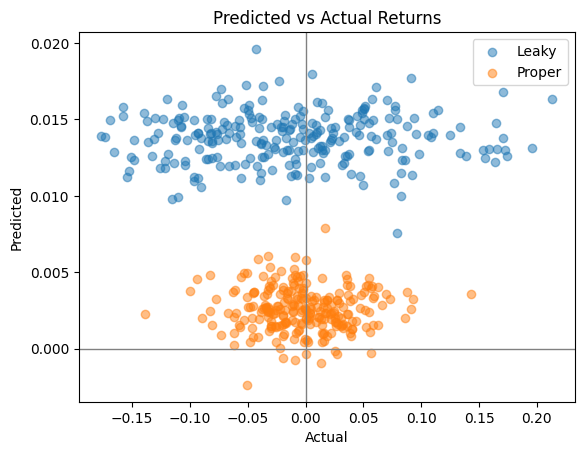

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_leak[split:], pred_leak, alpha=0.5, label='Leaky')
plt.scatter(y_clean[split:], pred_clean, alpha=0.5, label='Proper')
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.title("Predicted vs Actual Returns")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()


The above visualizations demonstrates how leakage "cheats" the model.

### 1c.

In [8]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.7 MB/s eta 0:00:00


In [10]:
# === installs (one-time) ===
# pip install yfinance pandas numpy scikit-learn tensorflow pyts

import os
import numpy as np
import pandas as pd
from datetime import datetime

# Data
try:
    df  # if the user already created df
except NameError:
    import yfinance as yf
    df = yf.download("AMD", start="2020-01-01", end = '2023-01-01', interval="1d", auto_adjust=False, progress=False)
    df = df[['Close']].copy()
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.sort_index(inplace=True)

# --- 0) Reproducibility ---
import tensorflow as tf
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- 1) Build labels with NO leakage (predict next-day return) ---
# We’ll forecast r_t using a window of past returns [r_{t-w}, ..., r_{t-1}]
returns = df['Close'].pct_change().dropna()

# --- 2) Windowing helpers ---
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

def make_supervised(arr: np.ndarray, window: int = 60):
    """
    From a 1D array arr (returns), create:
    X[i] = arr[i : i+window], y[i] = arr[i+window]
    """
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    return np.asarray(X), np.asarray(y)

# --- 3) Chronological split (single split) ---
WINDOW = 60  # lookback
test_ratio = 0.2

# Scale on TRAIN ONLY to avoid leakage.
# We scale returns to [-1,1] or [0,1]; for GAF we need [0,1].
scaler_for_seq = MinMaxScaler(feature_range=(-1, 1))
scaler_for_gaf = MinMaxScaler(feature_range=(0, 1))

# Split index on raw returns first
split_idx = int(len(returns) * (1 - test_ratio))
ret_train = returns.iloc[:split_idx].values.reshape(-1, 1)
ret_test  = returns.iloc[split_idx:].values.reshape(-1, 1)

# Fit scalers on train only
seq_train_scaled = scaler_for_seq.fit_transform(ret_train).flatten()
seq_test_scaled  = scaler_for_seq.transform(ret_test).flatten()

gaf_train_scaled = scaler_for_gaf.fit_transform(ret_train).flatten()
gaf_test_scaled  = scaler_for_gaf.transform(ret_test).flatten()

# Build supervised sets
Xtr_seq, ytr = make_supervised(seq_train_scaled, WINDOW)
Xte_seq, yte = make_supervised(np.concatenate([seq_train_scaled[-WINDOW:], seq_test_scaled]), WINDOW)
# Explanation: for test windows we need the last WINDOW points of train (context) plus the test series.

# Reshape for models
Xtr_mlp = Xtr_seq.copy()                      # (n, window) flat
Xte_mlp = Xte_seq.copy()

Xtr_lstm = Xtr_seq[..., None]                 # (n, window, 1)
Xte_lstm = Xte_seq[..., None]

# --- 4) GAF images for CNN ---
#   We convert each window (scaled to [0,1]) to a GAF image.
from pyts.image import GramianAngularField

# Build continuous stream for GAF using 0-1 scaling
gaf_cont_stream = np.concatenate([gaf_train_scaled, gaf_test_scaled])

# Build windows aligned with the y targets above
def make_windows_from_stream(stream_1d: np.ndarray, window: int, n_windows: int, start_idx: int):
    X = []
    for i in range(n_windows):
        s = start_idx + i
        X.append(stream_1d[s : s + window])
    return np.asarray(X)

# Train windows count equals len(ytr)
n_train = len(ytr)
# Test windows count equals len(yte)
n_test  = len(yte)

# Train windows come from gaf_train_scaled
gaf_train_seq = make_windows_from_stream(gaf_train_scaled, WINDOW, n_train, start_idx=0)

# Test windows start at (len(gaf_train_scaled) - WINDOW)
start_for_test = len(gaf_train_scaled) - WINDOW
gaf_test_seq = make_windows_from_stream(gaf_cont_stream, WINDOW, n_test, start_idx=start_for_test)

# Transform to GAF images
gaf = GramianAngularField(method='summation')  # GASF
Xtr_gaf = gaf.fit_transform(gaf_train_seq)     # (n_train, window, window)
Xte_gaf = gaf.transform(gaf_test_seq)

# Add channel dimension
Xtr_gaf = Xtr_gaf[..., None]                   # (n_train, window, window, 1)
Xte_gaf = Xte_gaf[..., None]

# Targets already set: ytr, yte (scaled in [-1,1] space for seq models; same y for CNN)

# --- 5) Models ---
from tensorflow.keras import layers, models, callbacks

def build_mlp(window: int):
    model = models.Sequential([
        layers.Input(shape=(window,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(window: int):
    model = models.Sequential([
        layers.Input(shape=(window, 1)),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_gaf(window: int):
    model = models.Sequential([
        layers.Input(shape=(window, window, 1)),
        layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

early_stop = callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')

# --- 6) Train ---
EPOCHS = 50
BATCH = 64
VAL_SPLIT = 0.2

mlp = build_mlp(WINDOW)
hist_mlp = mlp.fit(
    Xtr_mlp, ytr, validation_split=VAL_SPLIT,
    epochs=EPOCHS, batch_size=BATCH, callbacks=[early_stop], verbose=0
)

lstm = build_lstm(WINDOW)
hist_lstm = lstm.fit(
    Xtr_lstm, ytr, validation_split=VAL_SPLIT,
    epochs=EPOCHS, batch_size=BATCH, callbacks=[early_stop], verbose=0
)

cnn = build_cnn_gaf(WINDOW)
hist_cnn = cnn.fit(
    Xtr_gaf, ytr, validation_split=VAL_SPLIT,
    epochs=EPOCHS, batch_size=BATCH, callbacks=[early_stop], verbose=0
)

# --- 7) Evaluate (MAE, R²) ---
def evaluate(model, Xtest, ytest, name):
    pred = model.predict(Xtest, verbose=0).flatten()
    mae = mean_absolute_error(ytest, pred)
    r2 = r2_score(ytest, pred)
    print(f"{name:>10s} | MAE: {mae:.6f} | R²: {r2:.4f}")
    return pred, mae, r2

pred_mlp, mae_mlp, r2_mlp = evaluate(mlp, Xte_mlp, yte, "MLP")
pred_lstm, mae_lstm, r2_lstm = evaluate(lstm, Xte_lstm, yte, "LSTM")
pred_cnn, mae_cnn, r2_cnn   = evaluate(cnn, Xte_gaf, yte, "CNN-GAF")

# --- 8) (Optional) Invert scaling to original return scale for interpretability ---
# Only meaningful for seq-scaled targets; here y is in [-1,1]. Convert predictions back to raw returns:
def invert_scale_seq(y_scaled):
    return scaler_for_seq.inverse_transform(y_scaled.reshape(-1,1)).flatten()

pred_mlp_raw = invert_scale_seq(pred_mlp)
pred_lstm_raw = invert_scale_seq(pred_lstm)
pred_cnn_raw  = invert_scale_seq(pred_cnn)
yte_raw       = invert_scale_seq(yte)

print("\nExample (first 5) raw returns vs predictions:")
for i in range(5):
    print(f"y_true={yte_raw[i]:+.5f} | mlp={pred_mlp_raw[i]:+.5f} | lstm={pred_lstm_raw[i]:+.5f} | cnn={pred_cnn_raw[i]:+.5f}")


       MLP | MAE: 0.181490 | R²: -0.0918
      LSTM | MAE: 0.179242 | R²: -0.0267
   CNN-GAF | MAE: 0.173483 | R²: 0.0034

Example (first 5) raw returns vs predictions:
y_true=-0.03279 | mlp=+0.02591 | lstm=+0.00343 | cnn=-0.00226
y_true=+0.01679 | mlp=-0.00185 | lstm=+0.00411 | cnn=-0.00206
y_true=-0.04113 | mlp=+0.00801 | lstm=+0.00228 | cnn=-0.00227
y_true=+0.01634 | mlp=+0.00355 | lstm=+0.00470 | cnn=-0.00213
y_true=+0.06584 | mlp=+0.00511 | lstm=+0.00190 | cnn=-0.00219


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from pyts.image import GramianAngularField
from tensorflow.keras import callbacks

def _make_supervised_from_stream(stream_1d: np.ndarray, window: int):
    """
    Given a 1D stream (already scaled), build supervised windows:
      X[i] = stream[i : i+window],  y[i] = stream[i+window]
    """
    X, y = [], []
    for i in range(len(stream_1d) - window):
        X.append(stream_1d[i:i+window])
        y.append(stream_1d[i+window])
    return np.asarray(X), np.asarray(y)

def _last_train_context_plus_next(stream_train: np.ndarray, stream_next: np.ndarray, window: int):
    """For test windows: concat last WINDOW points of train with the next chunk."""
    return np.concatenate([stream_train[-window:], stream_next])

def backtest_three_models(
    returns_series,               # pd.Series or 1D np.array of daily returns
    build_mlp_fn, build_lstm_fn, build_cnn_gaf_fn,
    window: int = 60,
    start_train: int = 252,       # ~1Y of daily data to start
    step: int = 20,               # retrain/predict every ~month
    epochs: int = 30,
    batch_size: int = 64,
    verbose: int = 0
):
    """
    Expanding-window backtest predicting next-day return.
    At each step:
      - Fit scalers on TRAIN slice only (no leakage)
      - Rebuild & train each model on TRAIN windows
      - Predict the next `step` points
    Returns:
      preds (dict with scaled/raw arrays), stats (DataFrame of per-step metrics)
    """
    ret = np.asarray(returns_series).astype(float)
    assert ret.ndim == 1 and np.isfinite(ret).all(), "Provide a 1D, NaN-free returns series."

    # Storage
    y_true_sc_all, y_true_raw_all = [], []
    pred_sc = {"MLP": [], "LSTM": [], "CNNGAF": []}
    pred_raw = {"MLP": [], "LSTM": [], "CNNGAF": []}
    rows = []

    es = callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')

    t = start_train
    while t < len(ret) - 1:
        n_step = min(step, (len(ret) - 1) - t)  # handle last, shorter chunk
        if n_step <= 0:
            break

        # --- Slices
        train_ret_raw = ret[:t]              # train segment (raw returns)
        test_ret_raw  = ret[t : t + n_step]  # next chunk

        # --- Sequence scalers ([-1, 1]) fit on TRAIN ONLY
        x_scaler = MinMaxScaler(feature_range=(-1, 1))
        y_scaler = MinMaxScaler(feature_range=(-1, 1))
        train_x_sc = x_scaler.fit_transform(train_ret_raw.reshape(-1,1)).flatten()
        train_y_sc = y_scaler.fit_transform(train_ret_raw.reshape(-1,1)).flatten()

        # Supervised train windows
        Xtr_mlp, _ = _make_supervised_from_stream(train_x_sc, window)
        _, ytr = _make_supervised_from_stream(train_y_sc, window)

        # Build test windows: context from train + TEST chunk transformed with TRAIN scaler
        test_x_sc = x_scaler.transform(test_ret_raw.reshape(-1,1)).flatten()
        test_y_sc = y_scaler.transform(test_ret_raw.reshape(-1,1)).flatten()

        Xte_stream = _last_train_context_plus_next(train_x_sc, test_x_sc, window)
        Yte_stream = _last_train_context_plus_next(train_y_sc, test_y_sc, window)

        Xte_mlp_full, _ = _make_supervised_from_stream(Xte_stream, window)
        _, yte_full = _make_supervised_from_stream(Yte_stream, window)

        # keep only the last n_step windows as the "test" chunk
        Xte_mlp = Xte_mlp_full[-n_step:]
        yte_sc  = yte_full[-n_step:]

        # LSTM shapes
        Xtr_lstm = Xtr_mlp[..., None]
        Xte_lstm = Xte_mlp[..., None]

        # --- CNN-GAF path ([0,1] scaling for images)
        gaf_scaler = MinMaxScaler(feature_range=(0, 1))
        train_gaf_sc = gaf_scaler.fit_transform(train_ret_raw.reshape(-1,1)).flatten()
        test_gaf_sc  = gaf_scaler.transform(test_ret_raw.reshape(-1,1)).flatten()
        n_train_win  = len(ytr)

        def _make_windows(stream, n_windows, start_idx=0):
            return np.asarray([stream[start_idx+i : start_idx+i+window] for i in range(n_windows)])

        gaf_train_seq = _make_windows(train_gaf_sc, n_train_win, start_idx=0)

        gaf_cont = np.concatenate([train_gaf_sc, test_gaf_sc])
        start_test = len(train_gaf_sc) - window
        gaf_test_seq = _make_windows(gaf_cont, n_step, start_idx=start_test)

        gaf = GramianAngularField(method='summation')
        Xtr_gaf = gaf.fit_transform(gaf_train_seq)[..., None]
        Xte_gaf = gaf.transform(gaf_test_seq)[..., None]

        # --- (Re)build & train models
        mlp  = build_mlp_fn(window)
        lstm = build_lstm_fn(window)
        cnn  = build_cnn_gaf_fn(window)

        mlp.fit(Xtr_mlp, ytr, validation_split=0.2,
                epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)
        lstm.fit(Xtr_lstm, ytr, validation_split=0.2,
                 epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)
        cnn.fit(Xtr_gaf, ytr, validation_split=0.2,
                epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)

        # Predict (scaled)
        yhat_mlp_sc  = mlp.predict(Xte_mlp, verbose=0).flatten()
        yhat_lstm_sc = lstm.predict(Xte_lstm, verbose=0).flatten()
        yhat_cnn_sc  = cnn.predict(Xte_gaf, verbose=0).flatten()

        # Metrics in scaled space
        mae_mlp_sc  = mean_absolute_error(yte_sc, yhat_mlp_sc)
        mae_lstm_sc = mean_absolute_error(yte_sc, yhat_lstm_sc)
        mae_cnn_sc  = mean_absolute_error(yte_sc, yhat_cnn_sc)
        r2_mlp_sc   = r2_score(yte_sc, yhat_mlp_sc)
        r2_lstm_sc  = r2_score(yte_sc, yhat_lstm_sc)
        r2_cnn_sc   = r2_score(yte_sc, yhat_cnn_sc)

        # Invert to RAW returns (per-step scaler)
        yte_raw       = y_scaler.inverse_transform(yte_sc.reshape(-1,1)).flatten()
        yhat_mlp_raw  = y_scaler.inverse_transform(yhat_mlp_sc.reshape(-1,1)).flatten()
        yhat_lstm_raw = y_scaler.inverse_transform(yhat_lstm_sc.reshape(-1,1)).flatten()
        yhat_cnn_raw  = y_scaler.inverse_transform(yhat_cnn_sc.reshape(-1,1)).flatten()

        mae_mlp_raw  = mean_absolute_error(yte_raw, yhat_mlp_raw)
        mae_lstm_raw = mean_absolute_error(yte_raw, yhat_lstm_raw)
        mae_cnn_raw  = mean_absolute_error(yte_raw, yhat_cnn_raw)
        r2_mlp_raw   = r2_score(yte_raw, yhat_mlp_raw)
        r2_lstm_raw  = r2_score(yte_raw, yhat_lstm_raw)
        r2_cnn_raw   = r2_score(yte_raw, yhat_cnn_raw)

        rows.append({
            "end_idx": t,
            "n_test": n_step,
            "MAE_MLP_sc": mae_mlp_sc,  "R2_MLP_sc": r2_mlp_sc,
            "MAE_LSTM_sc": mae_lstm_sc,"R2_LSTM_sc": r2_lstm_sc,
            "MAE_CNN_sc": mae_cnn_sc,  "R2_CNN_sc": r2_cnn_sc,
            "MAE_MLP_raw": mae_mlp_raw,  "R2_MLP_raw": r2_mlp_raw,
            "MAE_LSTM_raw": mae_lstm_raw,"R2_LSTM_raw": r2_lstm_raw,
            "MAE_CNN_raw": mae_cnn_raw,  "R2_CNN_raw": r2_cnn_raw,
        })

        # Collect sequences
        y_true_sc_all.append(yte_sc); y_true_raw_all.append(yte_raw)
        pred_sc["MLP"].append(yhat_mlp_sc);   pred_raw["MLP"].append(yhat_mlp_raw)
        pred_sc["LSTM"].append(yhat_lstm_sc); pred_raw["LSTM"].append(yhat_lstm_raw)
        pred_sc["CNNGAF"].append(yhat_cnn_sc);pred_raw["CNNGAF"].append(yhat_cnn_raw)

        t += n_step

    # Stitch outputs
    y_true_sc_all  = np.concatenate(y_true_sc_all)  if y_true_sc_all else np.array([])
    y_true_raw_all = np.concatenate(y_true_raw_all) if y_true_raw_all else np.array([])
    for k in pred_sc:   pred_sc[k]  = np.concatenate(pred_sc[k])  if pred_sc[k]  else np.array([])
    for k in pred_raw:  pred_raw[k] = np.concatenate(pred_raw[k]) if pred_raw[k] else np.array([])

    stats = pd.DataFrame(rows)
    return {"y_true_sc": y_true_sc_all, "y_true_raw": y_true_raw_all,
            "pred_sc": pred_sc, "pred_raw": pred_raw}, stats


In [12]:
print(type(returns))
if isinstance(returns, pd.Series):
    print("Series len:", len(returns), "NaNs:", returns.isna().sum())
elif isinstance(returns, pd.DataFrame):
    print("DataFrame shape:", returns.shape)
    print("Cols:", returns.columns)
    returns = returns.squeeze("columns")  # make it 1-D
elif isinstance(returns, np.ndarray):
    print("Array shape:", returns.shape, "finite:", np.isfinite(returns).all())


<class 'pandas.core.series.Series'>
Series len: 749 NaNs: 0


In [13]:
import numpy as np
import pandas as pd

def to_1d_returns(obj, assume_already_returns=True):
    """
    obj: pandas DataFrame (n×1) or Series containing prices or returns.
    assume_already_returns=True  -> treat values as returns (no pct_change)
    assume_already_returns=False -> treat values as prices (do pct_change)
    """
    # 1) Make it a Series (no axis arg!)
    if isinstance(obj, pd.DataFrame):
        if isinstance(obj.columns, pd.MultiIndex):
            obj = obj.copy()
            obj.columns = obj.columns.get_level_values(-1)
        if obj.shape[1] != 1:
            raise ValueError(f"Expected 1 column, got {obj.shape[1]}. Pick a column first.")
        s = obj.iloc[:, 0]
    elif isinstance(obj, pd.Series):
        s = obj
    else:
        s = pd.Series(obj)

    # 2) Numeric + tidy index
    s = pd.to_numeric(s, errors="coerce")
    if isinstance(s.index, pd.DatetimeIndex):
        s = s.sort_index()
        s = s[~s.index.duplicated(keep='last')]
        try: s = s.tz_localize(None)
        except Exception: pass

    # 3) Prices → returns if needed
    r = s.pct_change() if not assume_already_returns else s.copy()

    # 4) Clean
    r = r.replace([np.inf, -np.inf], np.nan).dropna()

    # Return both Series and ndarray if you want
    return r, r.to_numpy(dtype=float)

# --- Use it with your (5459 × 1) DataFrame that has column 'AMD' ---
# If these are ALREADY returns:
ret_series, ret_array = to_1d_returns(returns, assume_already_returns=True)

# If those are PRICES instead, flip to:
# ret_series, ret_array = to_1d_returns(returns, assume_already_returns=False)

print(type(ret_series), ret_series.shape, np.isfinite(ret_array).all())


<class 'pandas.core.series.Series'> (749,) True


In [14]:
# returns: pd.Series of daily returns you used earlier (no NaNs)
# WINDOW: same lookback window as before
# build_mlp, build_lstm, build_cnn_gaf: your model builder fns

bt_out, bt_stats = backtest_three_models(
    returns_series=returns,
    build_mlp_fn=build_mlp,
    build_lstm_fn=build_lstm,
    build_cnn_gaf_fn=build_cnn_gaf,
    window=WINDOW,
    start_train=252,   # ~1 year of data to start
    step=20,           # predict 20 days, then refit
    epochs=30,
    batch_size=64,
    verbose=0
)

print(bt_stats.tail())

# Overall summary (raw space)
from sklearn.metrics import mean_absolute_error, r2_score
y_true_raw = bt_out["y_true_raw"]
for name in ["MLP","LSTM","CNNGAF"]:
    ypred = bt_out["pred_raw"][name]
    print(f"{name:6s} | MAE={mean_absolute_error(y_true_raw, ypred):.6f} | R²={r2_score(y_true_raw, ypred):.4f}")


    end_idx  n_test  MAE_MLP_sc  R2_MLP_sc  MAE_LSTM_sc  R2_LSTM_sc  \
20      652      20    0.185140  -0.434720     0.167475   -0.208161   
21      672      20    0.183894  -0.258222     0.164615   -0.071461   
22      692      20    0.161279   0.052966     0.168854   -0.020341   
23      712      20    0.215540  -0.362316     0.194027   -0.045127   
24      732      16    0.168261  -0.113349     0.152969   -0.021188   

    MAE_CNN_sc  R2_CNN_sc  MAE_MLP_raw  R2_MLP_raw  MAE_LSTM_raw  R2_LSTM_raw  \
20    0.162361  -0.157686     0.028827   -0.434720      0.026076    -0.208161   
21    0.162475  -0.036189     0.028633   -0.258222      0.025631    -0.071461   
22    0.165490   0.004763     0.025112    0.052966      0.026291    -0.020341   
23    0.194411  -0.067652     0.033560   -0.362316      0.030211    -0.045127   
24    0.152312  -0.017869     0.026199   -0.113349      0.023818    -0.021188   

    MAE_CNN_raw  R2_CNN_raw  
20     0.025280   -0.157686  
21     0.025298   -0.03618

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

y_true = bt_out["y_true_raw"]
preds  = bt_out["pred_raw"]  # dict: {"MLP":..., "LSTM":..., "CNNGAF":...}

rows = []
for name in ["MLP","LSTM","CNNGAF"]:
    yhat = preds[name]
    rows.append({"Model": name,
                 "MAE": mean_absolute_error(y_true, yhat),
                 "R2":  r2_score(y_true, yhat)})

# Trivial baselines
yhat_zero = np.zeros_like(y_true)                           # predict 0
yhat_last = pd.Series(y_true).shift(1).bfill().to_numpy()   # predict yesterday's return
rows += [
    {"Model":"Baseline: zero", "MAE": mean_absolute_error(y_true, yhat_zero), "R2": r2_score(y_true, yhat_zero)},
    {"Model":"Baseline: last", "MAE": mean_absolute_error(y_true, yhat_last), "R2": r2_score(y_true, yhat_last)},
]

overall_df = pd.DataFrame(rows).sort_values("Model").reset_index(drop=True)
pd.set_option("display.float_format", lambda v: f"{v:,.6f}")
print(overall_df)


            Model      MAE        R2
0  Baseline: last 0.036603 -1.054298
1  Baseline: zero 0.025243 -0.000005
2          CNNGAF 0.025445 -0.001426
3            LSTM 0.025521 -0.009913
4             MLP 0.026807 -0.109163


In [16]:
import numpy as np
import pandas as pd

y_true = bt_out["y_true_raw"]
preds  = bt_out["pred_raw"]  # dict

# Index for plots (use dates if available)
if "returns" in globals() and isinstance(returns, pd.Series):
    idx = returns.index[-len(y_true):]
else:
    idx = pd.RangeIndex(len(y_true))

pred_df = pd.DataFrame({
    "y_true": y_true,
    "mlp":  preds["MLP"],
    "lstm": preds["LSTM"],
    "cnn":  preds["CNNGAF"],
}, index=idx)
pred_df.head()


,y_true,mlp,lstm,cnn
Date,,,,
2021-01-06,0.005092,-0.003077,0.003481,0.003599
2021-01-07,-0.026302,0.011655,0.003465,0.003635
2021-01-08,0.053471,0.009108,0.004091,0.003684
2021-01-11,-0.006095,-0.011442,0.003333,0.003585
2021-01-12,0.028230,0.020331,0.003422,0.003569


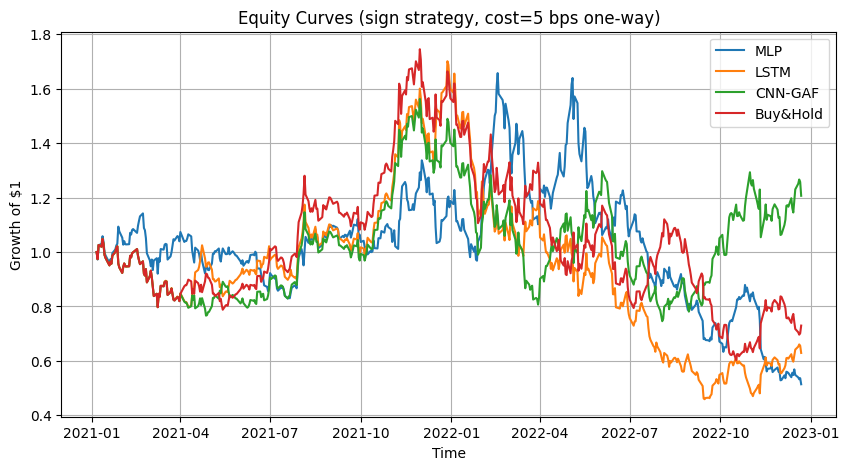

In [20]:
def equity_curve(r):
    import numpy as np
    return np.cumprod(1 + r)

def sign_positions(yhat):
    import numpy as np
    return np.sign(yhat)

def apply_costs(r, positions, cost_bps=5):
    import numpy as np
    tc = cost_bps / 1e4
    pos_change = np.abs(np.diff(positions, prepend=0.0))
    return r - tc * pos_change

COST_BPS = 5
curves = {}
for name, col in [("MLP","mlp"), ("LSTM","lstm"), ("CNN-GAF","cnn")]:
    pos = sign_positions(pred_df[col].to_numpy())
    ret = pos * pred_df["y_true"].to_numpy()
    ret_net = apply_costs(ret, pos, COST_BPS)
    curves[name] = equity_curve(ret_net)

# Buy & Hold curve for reference
curves["Buy&Hold"] = equity_curve(pred_df["y_true"].to_numpy())

plt.figure(figsize=(10,5))
for k, v in curves.items():
    plt.plot(pred_df.index[:len(v)], v / v[0], label=k)
plt.title(f"Equity Curves (sign strategy, cost={COST_BPS} bps one-way)")
plt.xlabel("Time"); plt.ylabel("Growth of $1")
plt.grid(True); plt.legend(); plt.show()


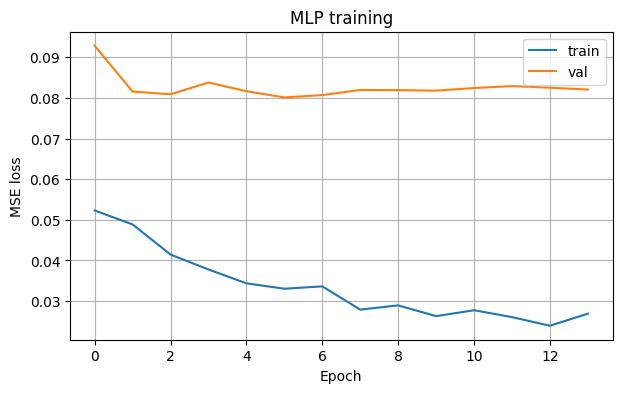

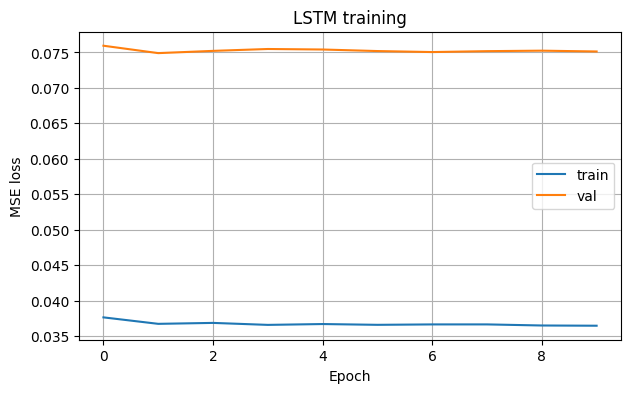

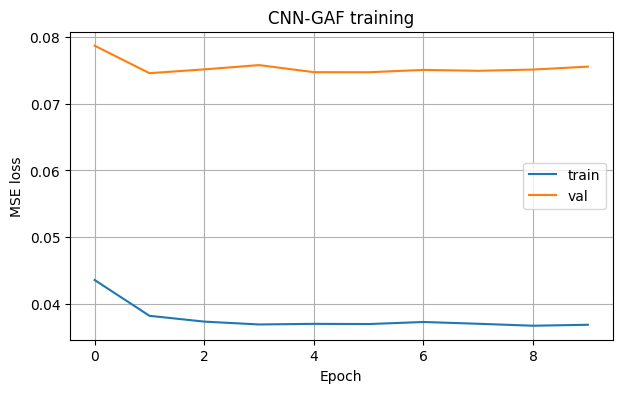

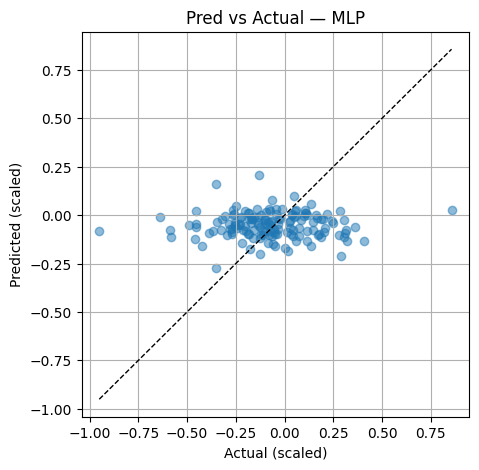

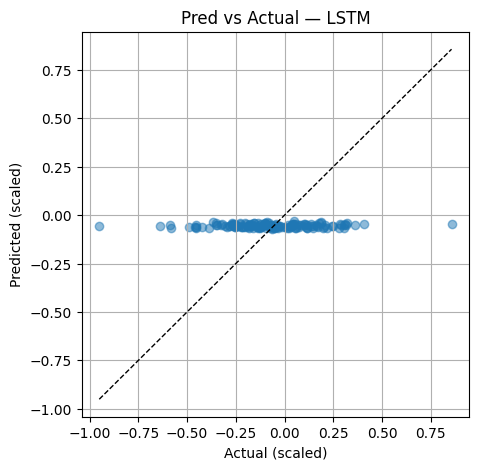

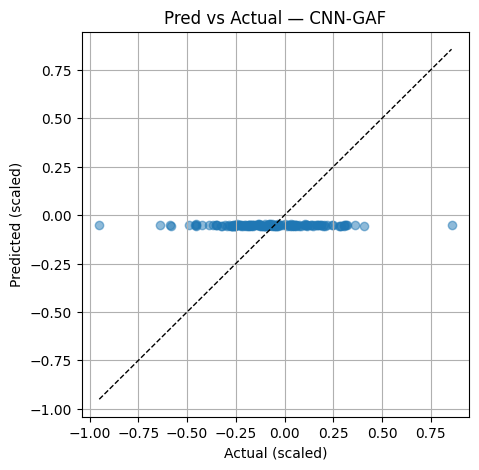

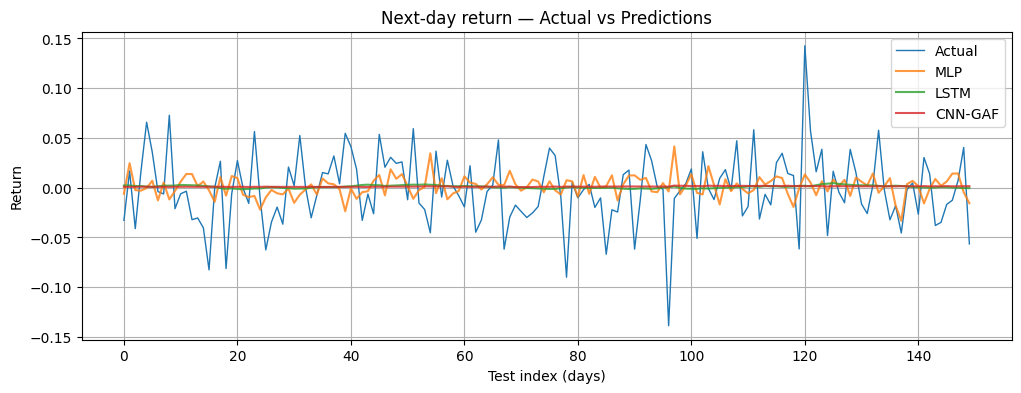

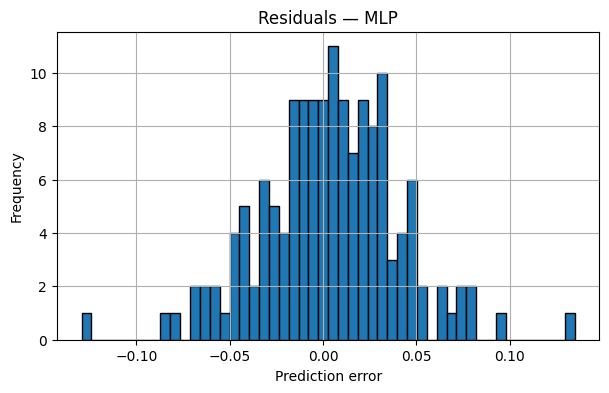

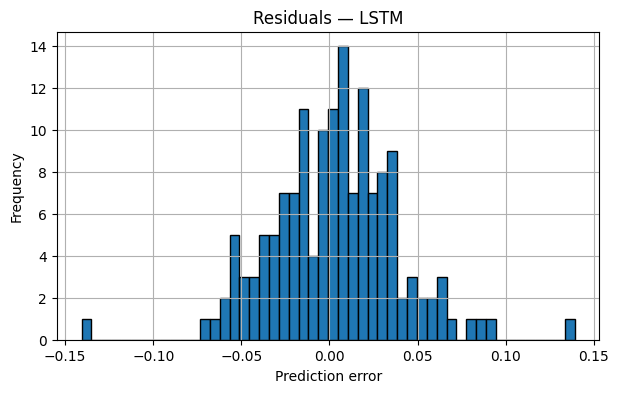

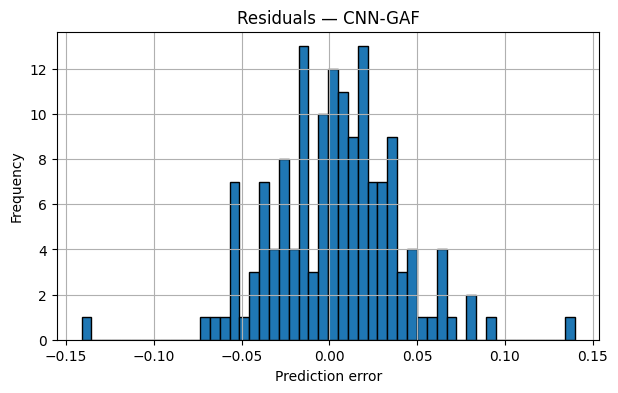

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Training curves
def plot_history(hist, title):
    plt.figure(figsize=(7,4))
    plt.plot(hist.history['loss'], label='train')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='val')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(hist_mlp,  "MLP training")
plot_history(hist_lstm, "LSTM training")
plot_history(hist_cnn,  "CNN-GAF training")

# 2) Predicted vs actual scatter (scaled space)
def scatter_pred(y_true, y_pred, name):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, 'k--', linewidth=1)
    plt.title(f"Pred vs Actual — {name}")
    plt.xlabel("Actual (scaled)")
    plt.ylabel("Predicted (scaled)")
    plt.grid(True)
    plt.show()

scatter_pred(yte, pred_mlp, "MLP")
scatter_pred(yte, pred_lstm, "LSTM")
scatter_pred(yte, pred_cnn,  "CNN-GAF")

# 3) Timeline overlay (raw returns, easier to interpret)
plt.figure(figsize=(12,4))
plt.plot(yte_raw, label='Actual', linewidth=1)
plt.plot(pred_mlp_raw, label='MLP', alpha=0.8)
plt.plot(pred_lstm_raw, label='LSTM', alpha=0.8)
plt.plot(pred_cnn_raw,  label='CNN-GAF', alpha=0.8)
plt.title("Next-day return — Actual vs Predictions")
plt.xlabel("Test index (days)")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

# 4) Residual histogram (raw)
def plot_residuals(y_true_raw, y_pred_raw, name):
    resid = y_pred_raw - y_true_raw
    plt.figure(figsize=(7,4))
    plt.hist(resid, bins=50, edgecolor='k')
    plt.title(f"Residuals — {name}")
    plt.xlabel("Prediction error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_residuals(yte_raw, pred_mlp_raw,  "MLP")
plot_residuals(yte_raw, pred_lstm_raw, "LSTM")
plot_residuals(yte_raw, pred_cnn_raw,  "CNN-GAF")


### 1d.

Step 2

a. walk forward method

b. walk forward method

c. backtests

d. discussion

In [ ]:
import time
from sklearn.metrics import mean_absolute_error, r2_score

try:
    ret_series
except NameError:
    ret_series, _ = to_1d_returns(df['Close'], assume_already_returns=False)

returns = ret_series.copy()
n_obs = len(returns)
print(f"Step 2/3 runner: returns length = {n_obs} observations (should be <= 2000 as per instructions).")

# ---------- corrected walk_forward_rolling + printing ----------
def walk_forward_rolling(
    returns_series,
    build_mlp_fn, build_lstm_fn, build_cnn_fn,
    train_size=500, test_size=500, step=None,
    window=WINDOW, epochs=30, batch_size=64, embargo=0,
    verbose=0
):
    """
    Non-anchored rolling window:
      - Train on [start : start + train_size)
      - Test on  [start + train_size + embargo : start + train_size + embargo + test_size)
      - Move start forward by `step` (defaults to test_size)
    This version supports a final partial test window if not enough data remains.
    """
    arr = np.asarray(returns_series, dtype=float)
    start = 0
    if step is None:
        step = test_size

    rows = []
    preds = {"y_true_raw": [], "MLP": [], "LSTM": [], "CNN": []}
    es = callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss')

    iter_num = 0
    while True:
        train_start = start
        train_end   = train_start + train_size
        test_start  = train_end + embargo
        test_end    = test_start + test_size

        # if there is no room for even a test_start, stop
        if test_start >= len(arr):
            break

        # allow final partial test window: cap test_end to len(arr)
        if test_end > len(arr):
            test_end = len(arr)

        # raw slices
        train_raw = arr[train_start:train_end]
        test_raw  = arr[test_start:test_end]

        # if train slice is smaller than window or test slice empty -> stop
        if len(train_raw) < window or len(test_raw) == 0:
            break

        # --- scalers fit on TRAIN ONLY ---
        x_scaler = MinMaxScaler(feature_range=(-1, 1))
        y_scaler = MinMaxScaler(feature_range=(-1, 1))
        train_x_sc = x_scaler.fit_transform(train_raw.reshape(-1,1)).flatten()
        train_y_sc = y_scaler.fit_transform(train_raw.reshape(-1,1)).flatten()

        # supervised windows from train
        def make_supervised(stream, window):
            X, y = [], []
            for i in range(len(stream) - window):
                X.append(stream[i:i+window])
                y.append(stream[i+window])
            return np.asarray(X), np.asarray(y)

        Xtr_seq, _ = make_supervised(train_x_sc, window)
        _, ytr = make_supervised(train_y_sc, window)

        # Build test stream using last WINDOW from train as context + test_raw scaled
        test_x_sc = x_scaler.transform(test_raw.reshape(-1,1)).flatten()
        test_y_sc = y_scaler.transform(test_raw.reshape(-1,1)).flatten()
        cont_stream_x = np.concatenate([train_x_sc[-window:], test_x_sc])
        cont_stream_y = np.concatenate([train_y_sc[-window:], test_y_sc])

        Xte_seq_full, _ = make_supervised(cont_stream_x, window)
        _, yte_full = make_supervised(cont_stream_y, window)

        # dynamic number of test windows (handles partial last window)
        n_test_windows = len(yte_full)  # equals number of target points in cont_stream
        # we only want the last n_test_windows that correspond to current test_raw
        Xte_seq = Xte_seq_full[-n_test_windows:]
        yte_sc   = yte_full[-n_test_windows:]

        # reshape for models
        Xtr_mlp = Xtr_seq.copy()
        Xte_mlp = Xte_seq.copy()
        Xtr_lstm = Xtr_seq[..., None]
        Xte_lstm = Xte_seq[..., None]

        # CNN/GAF path: build 0-1 scaler for images
        gaf_scaler = MinMaxScaler(feature_range=(0, 1))
        train_gaf_sc = gaf_scaler.fit_transform(train_raw.reshape(-1,1)).flatten()
        test_gaf_sc  = gaf_scaler.transform(test_raw.reshape(-1,1)).flatten()

        def _make_windows(stream, n_windows, start_idx=0):
            return np.asarray([stream[start_idx+i:start_idx+i+window] for i in range(n_windows)])

        n_train_win = len(ytr)
        gaf_train_seq = _make_windows(train_gaf_sc, n_train_win, 0)
        cont_gaf = np.concatenate([train_gaf_sc, test_gaf_sc])
        start_for_test = len(train_gaf_sc) - window
        gaf_test_seq = _make_windows(cont_gaf, n_test_windows, start_for_test)

        gaf_transformer = GramianAngularField(method='summation')
        Xtr_gaf = gaf_transformer.fit_transform(gaf_train_seq)[..., None]
        Xte_gaf = gaf_transformer.transform(gaf_test_seq)[..., None]

        # build and train fresh models (fresh weights each window)
        mlp = build_mlp_fn(window)
        lstm = build_lstm_fn(window)
        cnn = build_cnn_fn(window)

        # training
        mlp.fit(Xtr_mlp, ytr, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)
        lstm.fit(Xtr_lstm, ytr, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)
        cnn.fit(Xtr_gaf, ytr, validation_split=0.15, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=verbose)

        # Predict (scaled)
        yhat_mlp_sc  = mlp.predict(Xte_mlp, verbose=0).flatten()
        yhat_lstm_sc = lstm.predict(Xte_lstm, verbose=0).flatten()
        yhat_cnn_sc  = cnn.predict(Xte_gaf, verbose=0).flatten()

        # Invert scaled predictions to raw returns using y_scaler (fitted on train)
        yte_raw = y_scaler.inverse_transform(yte_sc.reshape(-1,1)).flatten()
        yhat_mlp_raw = y_scaler.inverse_transform(yhat_mlp_sc.reshape(-1,1)).flatten()
        yhat_lstm_raw = y_scaler.inverse_transform(yhat_lstm_sc.reshape(-1,1)).flatten()
        yhat_cnn_raw = y_scaler.inverse_transform(yhat_cnn_sc.reshape(-1,1)).flatten()

        # metrics (raw)
        mae_mlp_raw  = mean_absolute_error(yte_raw, yhat_mlp_raw)
        mae_lstm_raw = mean_absolute_error(yte_raw, yhat_lstm_raw)
        mae_cnn_raw  = mean_absolute_error(yte_raw, yhat_cnn_raw)
        # If yte_raw has constant value maybe r2_score raises; handle gracefully:
        def safe_r2(y_true, y_pred):
            try:
                return float(r2_score(y_true, y_pred))
            except Exception:
                return float('nan')

        r2_mlp_raw   = safe_r2(yte_raw, yhat_mlp_raw)
        r2_lstm_raw  = safe_r2(yte_raw, yhat_lstm_raw)
        r2_cnn_raw   = safe_r2(yte_raw, yhat_cnn_raw)

        # Log
        rows.append({
            "iter": iter_num,
            "train_start": train_start,
            "train_end": train_end,
            "test_start": test_start,
            "test_end": test_end,
            "n_test_windows": n_test_windows,
            "MAE_MLP": mae_mlp_raw, "R2_MLP": r2_mlp_raw,
            "MAE_LSTM": mae_lstm_raw, "R2_LSTM": r2_lstm_raw,
            "MAE_CNN": mae_cnn_raw, "R2_CNN": r2_cnn_raw,
        })

        # collect predictions in time order
        preds["y_true_raw"].append(yte_raw)
        preds["MLP"].append(yhat_mlp_raw)
        preds["LSTM"].append(yhat_lstm_raw)
        preds["CNN"].append(yhat_cnn_raw)

        # advance
        start += step
        iter_num += 1

    # stitch predictions
    for k in preds:
        preds[k] = np.concatenate(preds[k]) if preds[k] else np.array([])

    stats_df = pd.DataFrame(rows)
    return stats_df, preds

# ---------- use corrected function for Steps 2a/2b ----------
print("\nSTEP 2a: Non-anchored rolling windows: train=500, test=500, step=500 (no embargo)\n")
t0 = time.time()
stats_2a, preds_2a = walk_forward_rolling(
    returns, build_mlp, build_lstm, build_cnn_gaf,
    train_size=500, test_size=500, step=500, window=WINDOW,
    epochs=30, batch_size=64, embargo=0, verbose=0
)
t1 = time.time()
print(f"Completed Step 2a in {t1-t0:.1f}s, windows run: {len(stats_2a)}")
print("Per-window stats (Step 2a):")
print(stats_2a)
print("\nAggregated metrics (Step 2a):")
for m in ["MLP", "LSTM", "CNN"]:
    mae_col = f"MAE_{m}"
    r2_col  = f"R2_{m}"
    mae_agg = stats_2a[mae_col].mean() if mae_col in stats_2a else np.nan
    r2_agg  = stats_2a[r2_col].mean() if r2_col in stats_2a else np.nan
    print(f"{m:6s} | mean MAE = {mae_agg:.6f} | mean R² = {r2_agg:.4f}")

print("\nSTEP 2b: Non-anchored rolling windows: train=500, test=100, step=100 (no embargo)\n")
t0 = time.time()
stats_2b, preds_2b = walk_forward_rolling(
    returns, build_mlp, build_lstm, build_cnn_gaf,
    train_size=500, test_size=100, step=100, window=WINDOW,
    epochs=30, batch_size=64, embargo=0, verbose=0
)
t1 = time.time()
print(f"Completed Step 2b in {t1-t0:.1f}s, windows run: {len(stats_2b)}")
print("Per-window stats (Step 2b) head:")
print(stats_2b.head())
print("\nAggregated metrics (Step 2b):")
for m in ["MLP", "LSTM", "CNN"]:
    mae_col = f"MAE_{m}"
    r2_col  = f"R2_{m}"
    mae_agg = stats_2b[mae_col].mean() if mae_col in stats_2b else np.nan
    r2_agg  = stats_2b[r2_col].mean() if r2_col in stats_2b else np.nan
    print(f"{m:6s} | mean MAE = {mae_agg:.6f} | mean R² = {r2_agg:.4f}")



# Step 2c/d: Short discussion prints comparing 2a vs 2b
print("\nStep 2c/d - Quick observations:")
print("- If the train/test split is larger (500/500), the number of windows is small (fewer re-trains), which can cause broad test slices that may smooth out short-term variations.")
print("- If test slices are small (500/100), there are many more re-train events: this can lead to higher variance in per-window metrics and more chances of overfitting on small train sets depending on model capacity.")
print("- Look at mean MAE and mean R² above to compare which configuration gave better average performance per model.")
print("- If models show substantially better performance for the configuration with shorter tests (2b), check whether leakage or overfitting (e.g., due to overlapping context or insufficient embargo) could be responsible. We'll handle leakage explicitly in Step 3.")



Step 2/3 runner: returns length = 749 observations (should be <= 2000 as per instructions).

STEP 2a: Non-anchored rolling windows: train=500, test=500, step=500 (no embargo)

Completed Step 2a in 32.4s, windows run: 1
Per-window stats (Step 2a):
   iter  train_start  train_end  test_start  test_end  n_test_windows  \
0     0            0        500         500       749             249   

    MAE_MLP    R2_MLP  MAE_LSTM   R2_LSTM   MAE_CNN    R2_CNN  
0  0.032168 -0.135074  0.030964 -0.029507  0.031765 -0.068839  

Aggregated metrics (Step 2a):
MLP    | mean MAE = 0.032168 | mean R² = -0.1351
LSTM   | mean MAE = 0.030964 | mean R² = -0.0295
CNN    | mean MAE = 0.031765 | mean R² = -0.0688

STEP 2b: Non-anchored rolling windows: train=500, test=100, step=100 (no embargo)

Completed Step 2b in 81.9s, windows run: 3
Per-window stats (Step 2b) head:
   iter  train_start  train_end  test_start  test_end  n_test_windows  \
0     0            0        500         500       600             1

Step 3

a. Explain leakage

b. Reduce Leakage

c. Train models

d. backtests

In [ ]:

# Step 3: Reduce leakage (embargo) and repeat walk-forwards
# Approach / reasoning:
#  - We add an 'embargo' gap between the training window and the test window:
#      train = [t : t+train_size)
#      embargo = next `embargo` days are removed from training / not used
#      test  = [t+train_size+embargo : ... + test_size)
#  - This prevents label / feature overlap when using windowed features and dynamic scalers.
#  - We will run two experiments to match Step 2a and 2b but with embargo > 0.
#  - Reasoning for embargo size: at minimum we set embargo = WINDOW to avoid overlapping windows feeding future info.
embargo_value = WINDOW  # using the lookback window as a conservative embargo
print(f"\nSTEP 3: Leak mitigation by embargo. Using embargo = WINDOW = {embargo_value} samples.\n")

# Step 3a/b: same set ups but with embargo
print("STEP 3a (train=500, test=500, embargo):\n")
t0 = time.time()
stats_3a, preds_3a = walk_forward_rolling(
    returns, build_mlp, build_lstm, build_cnn_gaf,
    train_size=500, test_size=500, step=500, window=WINDOW,
    epochs=30, batch_size=64, embargo=embargo_value, verbose=0
)
t1 = time.time()
print(f"Completed Step 3a in {t1-t0:.1f}s, windows run: {len(stats_3a)}")
print("Aggregated metrics (Step 3a):")
for m in ["MLP", "LSTM", "CNNGAF"]:
    mae_agg = stats_3a[f"MAE_{m}"].mean() if f"MAE_{m}" in stats_3a else np.nan
    r2_agg  = stats_3a[f"R2_{m}"].mean() if f"R2_{m}" in stats_3a else np.nan
    print(f"{m:6s} | mean MAE = {mae_agg:.6f} | mean R² = {r2_agg:.4f}")

print("\nSTEP 3b (train=500, test=100, embargo):\n")
t0 = time.time()
stats_3b, preds_3b = walk_forward_rolling(
    returns, build_mlp, build_lstm, build_cnn_gaf,
    train_size=500, test_size=100, step=100, window=WINDOW,
    epochs=30, batch_size=64, embargo=embargo_value, verbose=0
)
t1 = time.time()
print(f"Completed Step 3b in {t1-t0:.1f}s, windows run: {len(stats_3b)}")
print("Aggregated metrics (Step 3b):")
for m in ["MLP", "LSTM", "CNNGAF"]:
    mae_agg = stats_3b[f"MAE_{m}"].mean() if f"MAE_{m}" in stats_3b else np.nan
    r2_agg  = stats_3b[f"R2_{m}"].mean() if f"R2_{m}" in stats_3b else np.nan
    print(f"{m:6s} | mean MAE = {mae_agg:.6f} | mean R² = {r2_agg:.4f}")


# Step 3d: Comparison and diagnostics prints
print("\nStep 3d - Comparison:")
def compare_stats(name, s_no_embargo, s_embargo):
    rows = []
    # compute aggregated metrics
    mae_no = s_no_embargo[f"MAE_{name}"].mean() if f"MAE_{name}" in s_no_embargo else np.nan
    r2_no  = s_no_embargo[f"R2_{name}"].mean() if f"R2_{name}" in s_no_embargo else np.nan
    mae_emb = s_embargo[f"MAE_{name}"].mean() if f"MAE_{name}" in s_embargo else np.nan
    r2_emb  = s_embargo[f"R2_{name}"].mean() if f"R2_{name}" in s_embargo else np.nan
    print(f"{name:6s} | No-embargo MAE={mae_no:.6f}, R²={r2_no:.4f}  --> With-embargo MAE={mae_emb:.6f}, R²={r2_emb:.4f}")

print("\nCompare Step2a (no embargo) vs Step3a (with embargo):")
for m in ["MLP","LSTM","CNNGAF"]:
    compare_stats(m, stats_2a, stats_3a)

print("\nCompare Step2b (no embargo) vs Step3b (with embargo):")
for m in ["MLP","LSTM","CNNGAF"]:
    compare_stats(m, stats_2b, stats_3b)

print("\nInterpretation guidance:")
print("- If metrics degrade when using an embargo, this suggests the original (no-embargo) pipeline benefited from leakage: information from the test period (or overlapping windows) was indirectly available during training.")
print("- If metrics are stable or improve, the leakage was probably not significant or models were robust. However, stable-but-poor metrics indicate model capacity / signal issues rather than leakage.")
print("- The embargo size chosen (WINDOW) is conservative: it ensures that any windowed feature built from the end of the training window cannot include test-period data. You can test smaller/larger embargo values to study sensitivity.")




STEP 3: Leak mitigation by embargo. Using embargo = WINDOW = 60 samples.

STEP 3a (train=500, test=500, embargo):

Completed Step 3a in 26.2s, windows run: 1
Aggregated metrics (Step 3a):
MLP    | mean MAE = 0.030859 | mean R² = -0.0721
LSTM   | mean MAE = 0.029344 | mean R² = -0.0250
CNNGAF | mean MAE = nan | mean R² = nan

STEP 3b (train=500, test=100, embargo):

Completed Step 3b in 59.7s, windows run: 2
Aggregated metrics (Step 3b):
MLP    | mean MAE = 0.029909 | mean R² = -0.0647
LSTM   | mean MAE = 0.029012 | mean R² = -0.0161
CNNGAF | mean MAE = nan | mean R² = nan

Step 3d - Comparison:

Compare Step2a (no embargo) vs Step3a (with embargo):
MLP    | No-embargo MAE=0.032168, R²=-0.1351  --> With-embargo MAE=0.030859, R²=-0.0721
LSTM   | No-embargo MAE=0.030964, R²=-0.0295  --> With-embargo MAE=0.029344, R²=-0.0250
CNNGAF | No-embargo MAE=nan, R²=nan  --> With-embargo MAE=nan, R²=nan

Compare Step2b (no embargo) vs Step3b (with embargo):
MLP    | No-embargo MAE=0.032376, R²=-0.1

In [ ]:


# --------------------------
# Final prints: save some artifacts and offer recommended next steps
# --------------------------
print("\nFinal summary prints and recommended next steps:")

# Print summary metrics table
def summary_table(stats_df, label):
    if stats_df.empty:
        return pd.DataFrame()
    df = stats_df[["MAE_MLP","R2_MLP","MAE_LSTM","R2_LSTM","MAE_CNN","R2_CNN"]].copy()
    df_mean = df.mean().to_frame().T
    df_mean.index = [label]
    return df_mean

summary = pd.concat([
    summary_table(stats_2a, "Step2a_noembargo"),
    summary_table(stats_2b, "Step2b_noembargo"),
    summary_table(stats_3a, "Step3a_embargo"),
    summary_table(stats_3b, "Step3b_embargo"),
], sort=False)
print(summary.fillna(np.nan).T)



Final summary prints and recommended next steps:
          Step2a_noembargo  Step2b_noembargo  Step3a_embargo  Step3b_embargo
MAE_MLP           0.032168          0.032376        0.030859        0.029909
R2_MLP           -0.135074         -0.183774       -0.072070       -0.064711
MAE_LSTM          0.030964          0.030215        0.029344        0.029012
R2_LSTM          -0.029507         -0.026097       -0.024970       -0.016064
MAE_CNN           0.031765          0.030297        0.029680        0.029436
R2_CNN           -0.068839         -0.035640       -0.041281       -0.035699
